In [26]:
import pickle 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix

In [27]:
# df_raw = pd.read_excel("MedicalCentre.xlsx")
with open('df_raw.pickle','rb') as read_file:
    df_raw = pickle.load(read_file)
df = df_raw.copy()

In [28]:
df["Gender"] = df['Gender'].replace({'F': 0, 'M': 1}).astype(int)
df["No-show"] = df['No-show'].replace({'No': 0, 'Yes': 1}).astype(int)
df['Handcap'].replace([2,3,4],1, inplace = True)
df['Age'] = df['Age'].astype(int)
print(df.loc[df.Age == -1, 'Age'].count())
print(df.loc[df.Age >= 100, 'Age'].count())
# print(df.Age.value_counts())
# df['Age'].replace(-1,np.NaN, inplace=True)
df = df[df['Age']>-1]
df = df[df['Age']<=100]

1
11


In [29]:
df['ScheduledDay_Day'] = df['ScheduledDay'].str.split(pat='T', expand = True)[0]
df['AppointmentDay_Day'] = df['AppointmentDay'].str.split(pat='T', expand = True)[0]

df['AppointmentDay_Time'] = df['AppointmentDay'].str.split(pat='T', expand = True)[1]
df['ScheduledDay_Time'] = df['ScheduledDay'].str.split(pat='T', expand = True)[1]

In [30]:
df['ScheduledDay_Time'] = df['ScheduledDay_Time'].str.translate({ord('Z'): None})

In [31]:
df['ScheduledDay_Hours'] = df['ScheduledDay_Time'].apply(lambda x:x[0:2])

In [32]:
df['ScheduledDay_Day'] = pd.to_datetime(df['ScheduledDay_Day'], infer_datetime_format=True)
df['AppointmentDay_Day'] = pd.to_datetime(df['AppointmentDay_Day'], infer_datetime_format=True)

In [33]:
df['ScheduledDay_Date'] = df['ScheduledDay_Day'].astype(str).apply(lambda x:x[-2:])
df['AppointmentDay_Date'] = df['AppointmentDay_Day'].astype(str).apply(lambda x:x[-2:])

In [34]:
df['day_difference'] = df['AppointmentDay_Day'] - df['ScheduledDay_Day']

In [35]:
df['day_difference'] = df['day_difference'].apply(lambda x: x.days) ### extract only the days 
# df['day_difference'].astype(int)

In [36]:
df.loc[df['day_difference'] < 0] = np.nan

In [37]:
df['appointment_weekday'] = df['AppointmentDay_Day'].apply(lambda x:x.isoweekday())
df['schedule_weekday'] = df['ScheduledDay_Day'].apply(lambda x:x.isoweekday())

In [38]:
# 似乎不去掉也毫无影响
# df['appointment_weekday'].replace(6,np.NaN, inplace=True)
# df['schedule_weekday'].replace(6,np.NaN, inplace=True)

In [39]:
df.dropna(inplace = True)
df['ScheduledDay_Hours'] = df['ScheduledDay_Hours'].astype(int)
df['ScheduledDay_Date'] = df['ScheduledDay_Date'].astype(int)
df['AppointmentDay_Date'] = df['AppointmentDay_Date'].astype(int)

In [40]:
appointments = df.groupby('PatientId').AppointmentID.count().reset_index()
appointments.columns = ['PatientId','prior_appointments']
appointments['prior_appointments'] = appointments['prior_appointments'].apply(lambda x:x-1)
df = df.merge(appointments, how = 'left', on = 'PatientId')

In [41]:
no_shows = df.groupby('PatientId')['No-show'].sum().reset_index()
no_shows.columns = ['PatientId','prior_no_shows']
no_shows['prior_no_shows'] = no_shows['prior_no_shows'].apply(lambda x:x-1)
df = df.merge(no_shows, how = 'left', on = 'PatientId')

df['prior_no_shows'].replace(-1,0, inplace = True)

In [42]:
# 事实证明这个去掉效果会好一点点
df['total_conditions'] = df['Hipertension']+df['Diabetes']+df['Handcap']+df['Alcoholism']

In [43]:
df.sort_values('AppointmentDay', inplace = True) 
df.drop_duplicates(subset='PatientId', keep = 'last', inplace = True)

In [44]:
df = df.drop(['PatientId','ScheduledDay','AppointmentDay','ScheduledDay_Day','AppointmentDay_Day','ScheduledDay_Time','AppointmentID','AppointmentDay_Time','Neighbourhood'], axis =1)

In [45]:
df.columns

Index(['Gender', 'Age', 'Scholarship', 'Hipertension', 'Diabetes',
       'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'ScheduledDay_Hours', 'ScheduledDay_Date', 'AppointmentDay_Date',
       'day_difference', 'appointment_weekday', 'schedule_weekday',
       'prior_appointments', 'prior_no_shows', 'total_conditions'],
      dtype='object')

In [46]:
df = df.drop(['Gender',
              'Hipertension',
              'Diabetes',
              'Alcoholism',
              'Handcap',
              'prior_appointments',
              'total_conditions',
              'SMS_received',
              'Scholarship'],
             axis =1)

In [47]:
df.columns

Index(['Age', 'No-show', 'ScheduledDay_Hours', 'ScheduledDay_Date',
       'AppointmentDay_Date', 'day_difference', 'appointment_weekday',
       'schedule_weekday', 'prior_no_shows'],
      dtype='object')

In [48]:
df.to_pickle('df.pickle')

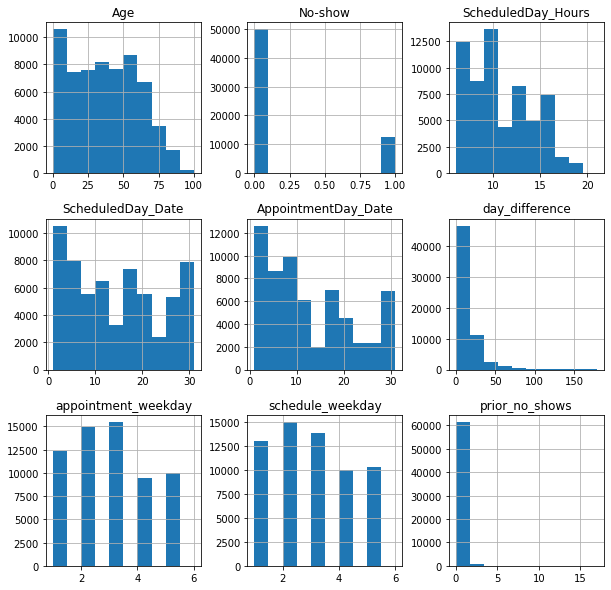

In [49]:
df.hist(bins=10,figsize=(10,10))
plt.show()

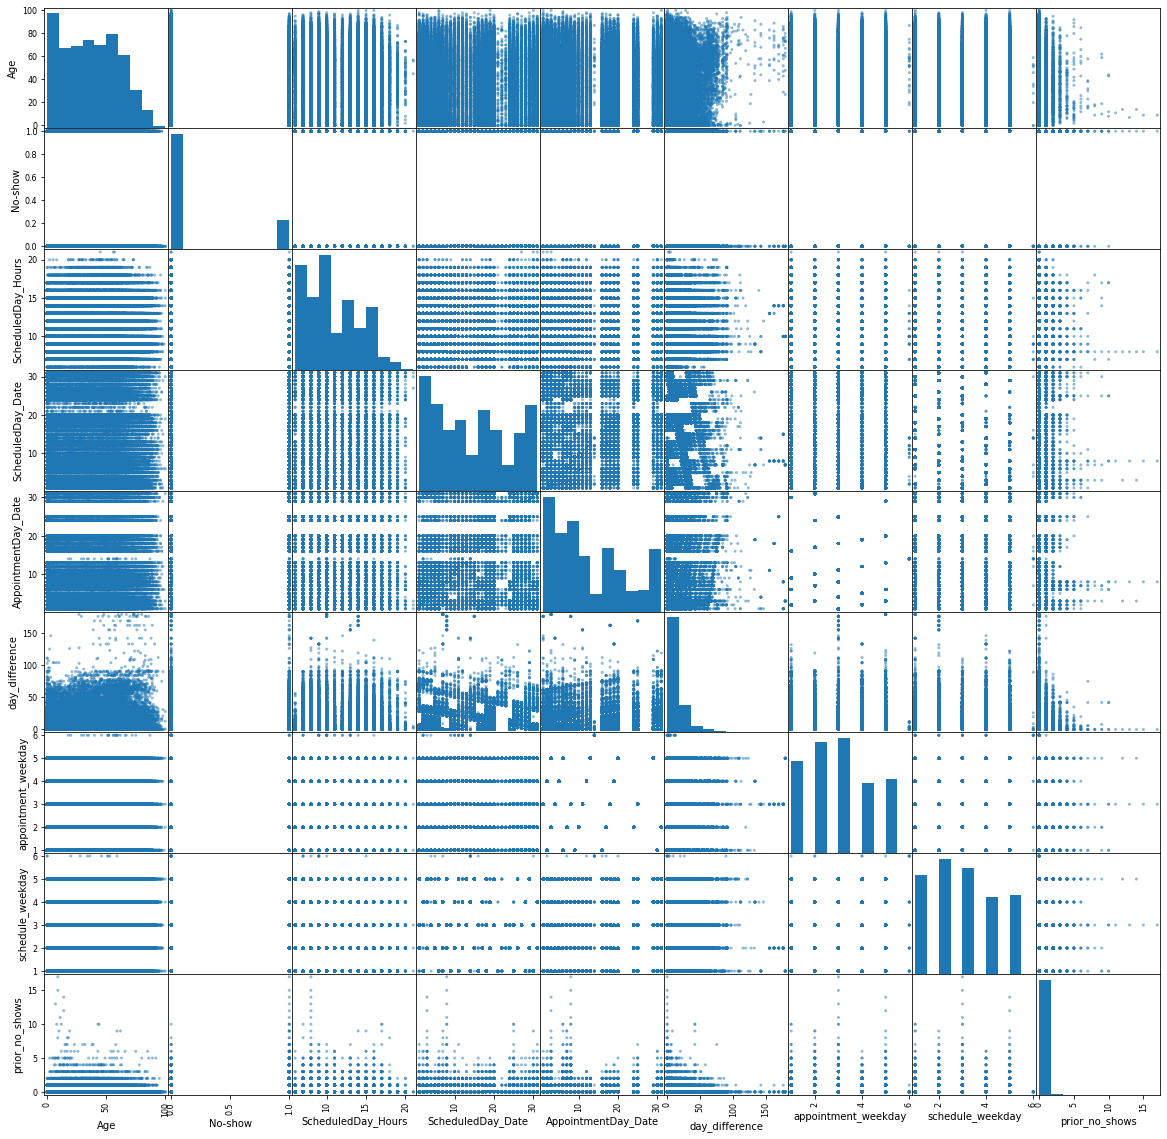

In [50]:
scatter_matrix(df,figsize=(20,20));